In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sps
from scipy.sparse import csr_matrix

In [37]:
n = 100     #formerly grid_size
grid = np.zeros([n, n], dtype=int)

separation_factor = 2/3     # horizontal separation of the plates
vertical_aspect = 0.8   # amount of vertical grid_size taken up by plate

y1 = int(0.5*n*(1 - vertical_aspect))
y2 = int(0.5*n*(1 + vertical_aspect))
assert 0 <= separation_factor <= 1
assert 0 <= vertical_aspect <= 1
offset = int(separation_factor * (n//2))
grid[y1:y2, offset] = 1
grid[y1:y2, n-offset-1] = -1

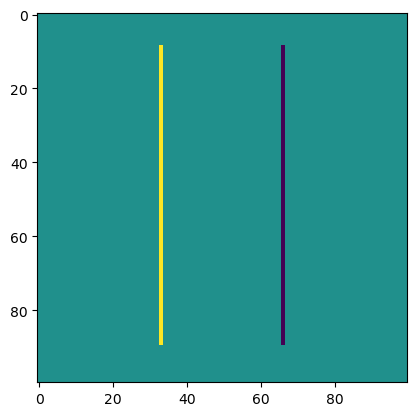

In [38]:
plt.imshow(grid, cmap='viridis')
plt.show()

In [39]:
diags = np.array([np.ones(n*n) * -4, np.ones(n*n), np.ones(n*n), np.ones(n*n), np.ones(n*n)])
laplacian = sps.spdiags(diags, [0, 1, -1, n, -n], n*n, n*n)

In [61]:
b = csr_matrix(grid.flatten().astype(float)).reshape(-1, 1)
A = laplacian.copy().tocsc()

In [64]:
x = sps.linalg.spsolve(A, b)
new_grid = x.reshape(100, 100)

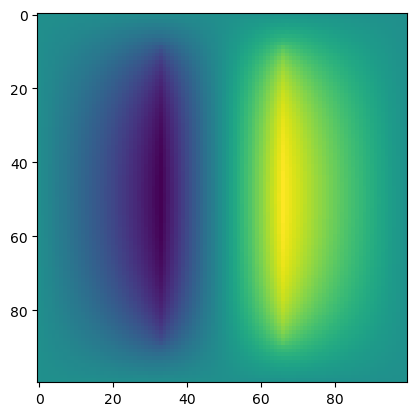

In [65]:
plt.imshow(new_grid, cmap='viridis')
plt.show()